# Dataset preparation

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F

In [3]:
from torchvision import transforms

ToTensor_transform = transforms.ToTensor()

In [5]:
import torchvision

train_dataset = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=ToTensor_transform)
valid_dataset = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=ToTensor_transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 112MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.75MB/s]


កែប្រែ dataset ទៅជា dataloader

In [6]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

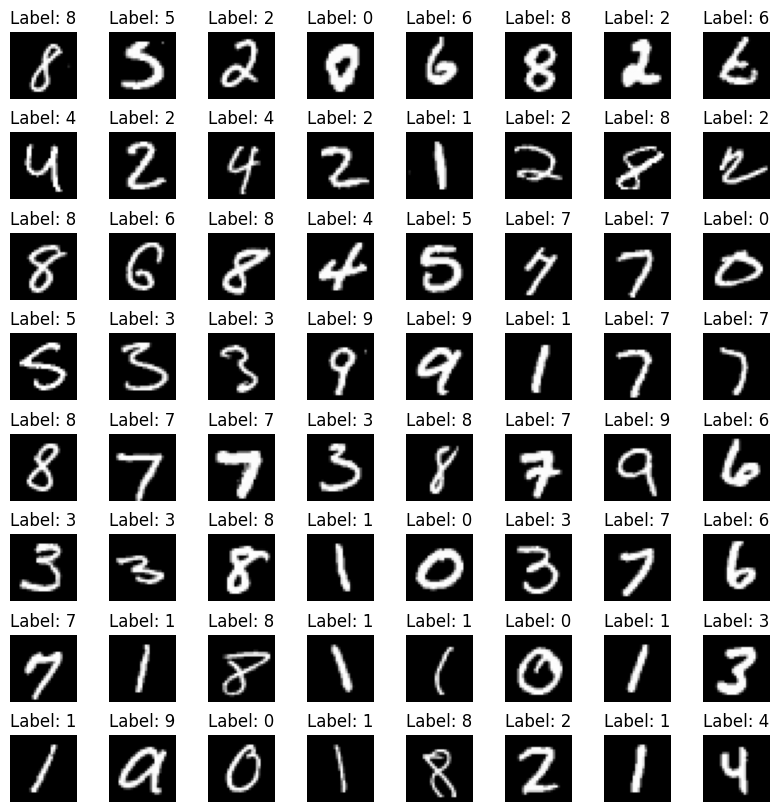

In [7]:
import matplotlib.pyplot as plt

def show_mnist_batch(dataloader):
    # Get one batch of images and labels
    images, labels = next(iter(dataloader))

    # Create an 8x8 figure
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat):
        # MNIST images are (1, 28, 28), squeeze to (28, 28) for imshow
        img = images[i].squeeze().numpy()

        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

# Run the function
show_mnist_batch(train_loader)

# Model Implementation

## Patch Embedding

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, n_channel, n_embed, patch_size):
        super().__init__()
        self.patch_embed = nn.Conv2d(n_channel, n_embed, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        x មានវិមាត្រ (batch_size, n_channel, img_size, img_size
        """
        x = self.patch_embed(x)     # (batch_size, n_embed, img_size // patch_size, img_size // patch_size)
        x = x.flatten(start_dim=2)   # (batch_size, n_embed, (img_size // patch_size) * (img_size // patch_size))
        x = x.transpose(1, 2)       # (batch_size, n_patch, n_embed) ដែល n_patch = (img_size // patch_size) * (img_size // patch_size)
        return x

In [12]:
x = torch.randn((4, 1, 28, 28))
patch_embed = PatchEmbedding(n_channel=1, n_embed=16, patch_size=7)
y = patch_embed(x)
y.shape

torch.Size([4, 16, 16])

## Vision Transformer

In [14]:
from dataclasses import dataclass


@dataclass
class ViTConfig:
    img_size: int
    patch_size: int
    n_channel: int
    n_class: int
    # block_size ស្មើ n_patch + 1
    n_embed: int
    n_head: int
    n_layer: int
    dropout: float = 0.0
    bias: bool = True


class VisionTransformer(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.config= config
        self.patch_embed = PatchEmbedding(config.n_channel, config.n_embed, config.patch_size)
        self.class_embed = nn.Embedding(1, config.n_embed)
        self.n_patch = (config.img_size // config.patch_size) ** 2
        self.pos_embed = nn.Embedding(self.n_patch+1, config.n_embed)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.n_embed,
            nhead=config.n_head,
            dim_feedforward=2*config.n_embed,
            dropout=config.dropout,
            batch_first=True,
            activation='gelu',
            norm_first=True,
            bias=config.bias
        )
        self.h = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layer)
        self.ln_f = nn.LayerNorm(config.n_embed)
        self.lm_head = nn.Linear(config.n_embed, config.n_class, bias=False)

    def forward(self, x):
        """
        x មានវិមាត្រ (batch_size, n_channel, img_size, img_sizeឳ
        """
        b = x.shape[0]

        tok_embed = self.patch_embed(x)     # (batch_size, n_patch, n_embed)
        cls_embed = self.class_embed(torch.zeros((b, 1), dtype=torch.long))
        tok_embed = torch.cat((cls_embed, tok_embed), dim=1)                # (batch_size, n_patch+1, n_embed)
        pos_embed = self.pos_embed(torch.arange(self.n_patch+1, dtype=torch.long))
        x = tok_embed + pos_embed
        x = self.h(x)
        x = x[:, 0, :]
        # x = torch.mean(x, dim=1)
        x = self.ln_f(x)
        x = self.lm_head(x)
        return x

In [15]:
config = ViTConfig(
    img_size=28,
    patch_size=7,
    n_channel=1,
    n_class=10,
    n_embed=64,
    n_head=4,
    n_layer=4,
    dropout=0.1,
    bias=True,
)
model = VisionTransformer(config)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [16]:
y = model(x)
y.shape

torch.Size([4, 10])

In [17]:
num_param = sum(p.numel() for p in model.parameters()) / 1e6
num_param

0.139008

# Optimizer, Loss function

In [18]:
device = torch.device('cpu')

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

# Train Loop

In [19]:
n_epoch = 5

for epoch in range(n_epoch):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch + 1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f" Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
 Batch   1: Loss = 2.2973, Accuracy = 9.38%
 Batch 101: Loss = 1.8449, Accuracy = 32.81%
 Batch 201: Loss = 0.9506, Accuracy = 70.31%
 Batch 301: Loss = 0.6432, Accuracy = 82.81%
 Batch 401: Loss = 0.5402, Accuracy = 87.50%
 Batch 501: Loss = 0.3380, Accuracy = 90.62%
 Batch 601: Loss = 0.2273, Accuracy = 93.75%
 Batch 701: Loss = 0.3859, Accuracy = 87.50%
 Batch 801: Loss = 0.3597, Accuracy = 87.50%
 Batch 901: Loss = 0.2821, Accuracy = 90.62%
==> Epoch 1 Summary: Total Loss = 664.4632, Accuracy = 77.48%

Epoch 2
 Batch   1: Loss = 0.1724, Accuracy = 95.31%
 Batch 101: Loss = 0.3970, Accuracy = 84.38%
 Batch 201: Loss = 0.1627, Accuracy = 90.62%
 Batch 301: Loss = 0.3080, Accuracy = 92.19%
 Batch 401: Loss = 0.1433, Accuracy = 98.44%
 Batch 501: Loss = 0.1398, Accuracy = 98.44%
 Batch 601: Loss = 0.1726, Accuracy = 96.88%
 Batch 701: Loss = 0.2475, Accuracy = 93.75%
 Batch 801: Loss = 0.2210, Accuracy = 92.19%
 Batch 901: Loss = 0.1183, Accuracy = 98.44%
==> Epoch 2 Summary: 

# Validation

In [20]:
model.eval()
correct = 0.0
total = 0


with torch.inference_mode():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 97.28%


In [ ]:
from timm.models.vision_transformer import PatchEmbed
from timm.models.vision_transformer import VisionTransformer